# PriorCVAE: scalable MCMC parameter inference with Bayesian deep generative modelling

## PriorCVAE with binary condition $c$


- Draws from a prior such as a GP with conditioning on hyperparameter $c$, are encoded with a CVAE; $c$ is the binary condition; lengthscale can take two possible values: 0.1 if $u =1$, and 0.4 if $u=0$, i.e. $\text{lengthscale} = 0.1* u + 0.4 * (1-u)$
- Once trained, the decoder from this trained CVAE is fixed. 
- Fully Bayesian inference with MCMC is used to combine a likelihood with a prior to infer a posterior. The prior is the drop-in prior expressed as the trained CVAE decoder, which is an approximation to the true prior from the previous step. A hyperprior is placed on $c$, with given draws from this prior passed to the CVAE decoder.





In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

# check versions
print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

0.10.1
0.3.25
1.12.1
3.8.16


In [2]:
# set device
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
args = {"seed": 0,
        
        # architecture
        "conditional": True,   # CVAE if True, VAE otherwise
        "input_dim": 100,
        "hidden_dim": 70,
        "z_dim": 50,
        
        # data generation
        "new_data": False,      # set to True to generate new data. Otherwise read from file
        "save_data": False,     # set to True to save generated training and test datasets
        "samples": 100000,
        
        # VAE setup
        "n_epochs": 250,      
        "batch_size": 1000,
        "learning_rate": 1e-3,
        "train_vae": False,      # set to True to train VAE
        "save_vae": False,
        "load_vae": True,      # set to True to load trained CVAE
        "print_loss": True,
        "vae_sd": 1, 
        
        # MCMC setup
        "num_warmup": 1000,
        "num_samples": 100000,
        "num_chains": 4,
        "thinning": 1,
        "c": 1
       }

## GP priors

In [6]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

def GP(gp_kernel, x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, u=None):
    
    if u==None:
        u = numpyro.sample("u", npdist.Bernoulli(0.5)).reshape(1) 
    else:
        u = numpyro.deterministic("u", jnp.array([u]))

    if length==None:  
        length = 0.1* u + 0.4 * (1-u)
            
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)

## Generate data - 1d GP

In [7]:
class GP1D(Dataset):
    def __init__(self, n_dataPoints=100, 
                       n_samples=10000, 
                       x_lim_low = 0, 
                       x_lim_high = 1,
                       ls = None,
                       u=None
                 ): 
        self.n_dataPoints = n_dataPoints
        self.n_samples = n_samples
        self.x_lim_low = x_lim_low
        self.x_lim_high = x_lim_high
        self.u = u
        self.ls = ls
        self.x, self.y, self.u = self.__simulatedata__()
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx=0):
        return(self.x[idx], self.y[idx], self.u[idx])

    def __simulatedata__(self):
        rng_key = rnd.randint(0, 912393890428)
        rng_key, _ = random.split(random.PRNGKey(rng_key))
        x = np.linspace(self.x_lim_low, self.x_lim_high, self.n_dataPoints)   
        gp_predictive = Predictive(GP, num_samples=self.n_samples)  
        all_draws = gp_predictive(rng_key, x=x, gp_kernel = exp_sq_kernel, jitter=1e-6, length=self.ls, u=self.u)

        u_draws = np.array(all_draws['u'])
        gp_draws = np.array(all_draws['y'])
        
        return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, u_draws)

(-0.5, 1.5)

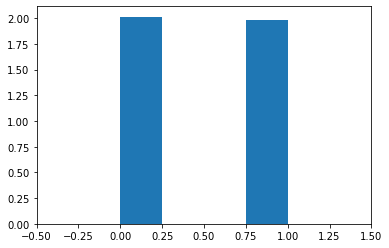

In [8]:
# what lengthscales are we generating?

dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=10000, x_lim_low=0, x_lim_high=1)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

u_dataset = dataset.u
plt.hist(u_dataset, density=True, bins=4) 
plt.xlim(-0.5,1.5)

Text(0.5, 1.0, 'realizations of a Gaussian process')

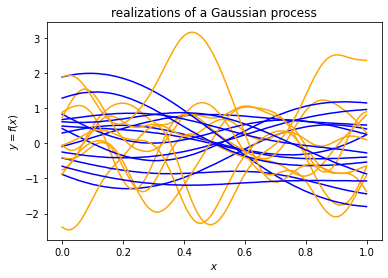

In [9]:
# what trajectories are we generating?
fig = plt.figure()
ax = fig.add_subplot(111)
for no, dt in enumerate(dataloader):
    if dt[2] == 0:
        col = 'blue'  
    else:
        col = 'orange'
    ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), color=col)
    if no > 20: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('realizations of a Gaussian process')

Loading data


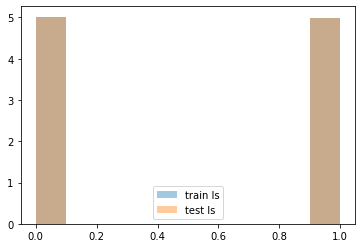

In [10]:
###### create and save or read training and test data

cwd = os.getcwd()
train_ds_name = 'gp1d_n' + str(args["input_dim"]) + '_binary_train.pt'
test_ds_name = 'gp1d_n' + str(args["input_dim"]) + '_binary_test.pt'
PATH_train = cwd+ F"/data/gp1d/{train_ds_name}" 
PATH_test =  cwd+F"/data/gp1d/{test_ds_name}" 
    
if args["new_data"] == True:
    print("Generating new data")
    train_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"])
    test_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"])
    if args["save_data"] == True:
        print("Saving new data")
        torch.save(train_ds, PATH_train)
        torch.save(test_ds, PATH_test)
else:
    print("Loading data")
    train_ds = torch.load(PATH_train)
    test_ds = torch.load(PATH_test)
    
test_dl = DataLoader(test_ds, batch_size=args["batch_size"], shuffle=True)
train_dl = DataLoader(train_ds, batch_size=args["batch_size"], shuffle=True)


# check distribution of the condition in training and test data
u_train = train_ds.u
u_test = test_ds.u
plt.hist(u_train, density=True, alpha=0.4, label="train ls") 
plt.hist(u_test, density=True, alpha=0.4, label="test ls") 
#plt.xlim(-0.5,1.5)
plt.legend()
plt.show()

## CVAE architecture

In [11]:
class Encoder(nn.Module):
    ''' This the encoder part of CVAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim, conditional):
        super().__init__()
        self.conditional = conditional
        if self.conditional:
            input_dim = input_dim + 1
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.sd = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x, c=None):
        if self.conditional:
            c = c[:, None]
            x = torch.cat((x, c), dim=-1)

        hidden = torch.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_sd = self.sd(hidden)
        return z_mu, z_sd


In [12]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self,z_dim, hidden_dim, input_dim,  conditional):
        super().__init__()
        
        self.conditional = conditional
        if self.conditional:
            z_dim = z_dim + 1
            
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z, c):
        
        if self.conditional:
            c = c[:, None]
            z = torch.cat((z, c), dim=-1)

        hidden = torch.relu(self.linear(z))
        pred = self.out(hidden)
        return pred

In [13]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 conditional=False):
        
        super().__init__()        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, conditional) 
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, conditional)

    def reparameterize(self, z_mu, z_sd):
        '''During training random sample from the learned ZDIMS-dimensional
           normal distribution; during inference its mean.
        '''
        if self.training:
            std = torch.exp(z_sd / 2)
            eps = torch.randn_like(std)
            return (eps.mul(std).add_(z_mu))
        else:
            return z_mu

    def forward(self, x, c=None):
        z_mu, z_sd = self.encoder(x, c)
        x_sample = self.reparameterize(z_mu, z_sd)
        generated_x = self.decoder(x_sample, c)
        return generated_x, z_mu,z_sd

In [14]:
def calculate_loss(y, reconstructed_y, mean, log_sd, vae_sd=args["vae_sd"]):

    # Compute the negative log-likelihood of the Gaussian distribution
    RCL = -torch.sum(- 0.5 * ((y - reconstructed_y) / vae_sd) ** 2)

    # Compute the KL divergence
    KLD = -0.5 * torch.sum(1 + log_sd - mean.pow(2) - log_sd.exp())

    return RCL + KLD

## Train PriorCVAE

In [15]:
# 1) Model
input_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
z_dim = args["z_dim"]
conditional = args["conditional"]

model = VAE(input_dim, hidden_dim, z_dim, conditional)

# 2) optimizer
optimizer = optim.Adam(model.parameters(), lr=args["learning_rate"])       
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

loss_history_train = []
loss_history_test = []


In [16]:
def calc_loss(model, data, loss_fn):
    
    model.eval()
    with torch.no_grad():
        total_loss = 0

        for i, (_, y, ls) in enumerate(data):    
            y = y.to(device)
            if args["conditional"]:
                ls = ls.to(device)
                reconstructed_y, z_mu, z_sd = model(y, ls) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            loss_i = loss_fn(y, reconstructed_y, z_mu, z_sd) 
            total_loss += loss_i.item()
            
    return total_loss / len(data)

In [17]:
num_epochs = args['n_epochs']

best_model = model

if args["train_vae"] == True:
    
    start_time = time.time()

    for epoch in range(num_epochs):
        
        # Set the model back to training mode
        model.train(True)
        
        # batch training
        for i, (_, y, ls) in enumerate(train_dl):

            # Clear the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y = y.to(device)

            if args["conditional"]:
                ls = ls.to(device)
                reconstructed_y, z_mu, z_sd = model(y, ls) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            # training loss on the batch    
            loss_tr = calculate_loss(y, reconstructed_y, z_mu, z_sd) 
            
            # Backward pass
            loss_tr.backward()
    
            # Update the weights
            optimizer.step()
            
        # Calculate the training loss for the epoch
        train_loss = calc_loss(model, train_dl, calculate_loss)
        loss_history_train.append(train_loss)
        
        # Set the model to evaluation mode
        model.eval()
  
        # Calculate the test loss for the epoch
        test_loss = calc_loss(model, test_dl, calculate_loss)
        loss_history_test.append(test_loss)
        
        if epoch==0:
            best_loss = test_loss
        else:
            if test_loss < best_loss:
                best_model = model
                best_loss = test_loss
        
        # Print loss
        if args["print_loss"] == True:
            print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Test loss = {test_loss:.4f}")
        
    end_time = time.time()
    t_elapsed = end_time - start_time
    
    # Print elapsed time
    print(f"Elapsed time = {t_elapsed:.4f}")

    plt.figure()
    plt.plot(np.arange(len(loss_history_train)), loss_history_train, label="train loss")
    plt.plot(np.arange(len(loss_history_test)), loss_history_test, label="test loss")
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    plt.title("Train and test loss, PriorCVAE")
    plt.show()

In [22]:
if args["train_vae"] == True:
    # Print elapsed time
    print(f"Elapsed time = {t_elapsed:.4f} s")
    print(f"Elapsed time = {t_elapsed/60:.4f} min")
    print(f"Elapsed time = {t_elapsed/(60*60):.4f} h")
    
    # plot the latest epochs 
    start_ind = 100
    plt.figure()
    plt.plot(np.arange(len(loss_history_train[start_ind:])), loss_history_train[start_ind:], label="train loss")
    plt.plot(np.arange(len(loss_history_test[start_ind:])), loss_history_test[start_ind:], label="test loss")
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    plt.title("Train and test losses, PriorCVAE")
    plt.show()

In [23]:
args["save_vae"]

False

In [34]:
model.state_dict()['encoder.linear.weight'] == best_model.state_dict()['encoder.linear.weight']

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [35]:
model = best_model
del best_model

In [24]:
import pickle

model_save_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"]) + '_binary.pt'
loss_train_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"]) +'_loss_train_binary'
loss_test_name =  'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"]) +'_loss_test_binary'
print(model_save_name) 
print(loss_train_name) 
print(loss_test_name) 

PATH = cwd + F"/trained_models/{model_save_name}" 
loss_train_name = cwd +"/trained_models/" + loss_train_name
loss_test_name = cwd + "/trained_models/" + loss_test_name

if args["save_vae"] == True:    
    print("VAE model saved")
    torch.save(model.state_dict(), PATH)
    
    with open(loss_train_name, "wb") as fp:  
        pickle.dump(loss_history_train, fp)
    with open(loss_test_name, "wb") as fp:  
        pickle.dump(loss_history_test, fp)
        
elif args["load_vae"] == True:
    model.load_state_dict(torch.load(PATH))
    
    with open(loss_train_name, "rb") as fp:   
        loss_history_train = pickle.load(fp)
    with open(loss_test_name, "rb") as fp:   
        loss_history_test = pickle.load(fp)

    print("CVAE model loaded")
else:
    print("no model loaded")


PriorCVAE_gp1d_n100_h70_z50_epochs250_b1000_binary.pt
PriorCVAE_gp1d_n100_h70_z50_epochs250_b1000_loss_train_binary
PriorCVAE_gp1d_n100_h70_z50_epochs250_b1000_loss_test_binary
CVAE model loaded


Text(0.5, 1.0, 'function realizations')

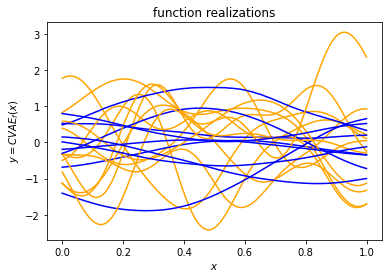

In [25]:
###### Sampling 5 draws from learnt model
model.eval() # model in eval mode

n_samps = 20
z = torch.randn(n_samps, z_dim).to(device) # random draw
c = torch.bernoulli(torch.ones(n_samps) * 0.5)

with torch.no_grad():
    sampled_y = model.decoder(z, c)

fig = plt.figure()
ax = fig.add_subplot(111)
for no, y in enumerate(sampled_y):
    if c[no] == 0:
        col = 'blue'  
    else:
        col = 'orange'
    ax.plot(train_ds.x[0], y.cpu().numpy(), color=col)

ax.set_xlabel('$x$')
ax.set_ylabel('$y=CVAE_f(x)$')
ax.set_title('function realizations')

## Visualise trajectories - GP and PriorCVAE

Text(0, 0.5, '$y=f_{CVAE}(x)$')

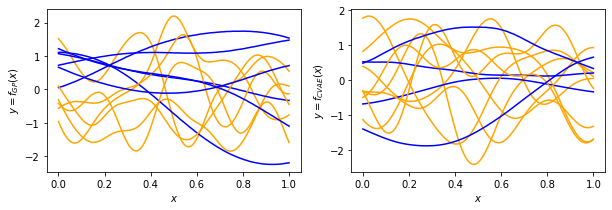

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

for no, dt in enumerate(dataloader):
    if dt[2] == 0:
        col = 'blue'  
    else:
        col = 'orange'
    ax[0].plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), color=col)
    if no > 10: break
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y=f_{GP}(x)$')

for no, y in enumerate(sampled_y):
    if c[no] == 0:
        col = 'blue'  
    else:
        col = 'orange'
    ax[1].plot(train_ds.x[0], y.cpu().numpy(), color=col)
    if no > 10: break

ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y=f_{CVAE}(x)$')


## Visual diagnostics of how well we have learnt

In [27]:
def demo_plots(u=0, plot_gp=True, plot_cov=False, n_samps=100000):

    dataset = GP1D(n_dataPoints=100, n_samples=n_samps, u=u)

    gp_draws = dataset.y
    x = dataset.x[0,:]
    _ , n_samps = gp_draws.shape

    model.eval() # model in eval mode
    z = torch.randn(n_samps, z_dim).to(device) # random draw
    c = torch.bernoulli(torch.ones(n_samps) * u)

    with torch.no_grad():
        vae_draws = model.decoder(z, c).numpy().transpose()

    gp_draws = gp_draws.transpose()

    #print(gp_draws.shape)
    #print(vae_draws.shape)

    mean_gp = np.nanmean(gp_draws, axis=1)
    q025_gp = np.quantile(gp_draws, 0.025, axis=1)
    q975_gp = np.quantile(gp_draws, 0.975, axis=1)
    #print(mean_gp.shape)

    mean_vae = np.nanmean(vae_draws, axis=1)
    q025_vae = np.quantile(vae_draws, 0.025, axis=1)
    q975_vae = np.quantile(vae_draws, 0.975, axis=1)

    #print(mean_vae.shape)

    #print(q025_gp)
    #print(q025_vae)
    #print(q975_gp)
    #print(q975_vae)
  
    if plot_gp==True:
        # plot results
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

        _min, _max = -3, 3
        lines_alpha_gp = 0.5
        lines_alpha_vae = 0.5
        N_lines = 20

        ttl="GP priors we want to encode, c=" + str(u)
        ylbl='$y=f_{GP}(x)$'

        for j in range(N_lines):
            #axs[0].plot(x, gp_draws[:,j], alpha=lines_alpha_gp, color="darkgreen", label="")
            axs[0].plot(x, gp_draws[:,j], alpha=lines_alpha_gp, label="", color="darkgreen", linewidth=0.8)

        axs[0].plot(x, gp_draws[:,0], alpha=lines_alpha_gp, color="darkgreen", label="GP draws", linewidth=0.8)  
        axs[0].fill_between(x, q025_gp[0], q975_gp[1], alpha=0.1, interpolate=True, label="95% BCI")
        axs[0].plot(x, mean_gp, label="mean")
        axs[0].legend(loc=4)
        axs[0].set_ylim([_min, _max])
        axs[0].set_xlabel('$x$')
        axs[0].set_ylabel(ylbl)
        axs[0].set_title(ttl)

        ttl="Priors learnt by PriorCVAE, c=" + str(u)
        ylbl='$y=f_{PriorCVAE}(x)$'

        for j in range(N_lines):
            #axs[1].plot(x, vae_draws[:,j], alpha=lines_alpha_vae, color="darkgreen", label="")
            axs[1].plot(x, vae_draws[:,j], alpha=lines_alpha_vae, label="", color="darkgreen", linewidth=0.8)

        axs[1].plot(x, vae_draws[:,0], alpha=lines_alpha_vae, color="darkgreen", label="PriorCVAE draws", linewidth=0.8)  
        axs[1].fill_between(x, q025_vae[0], q975_vae[1], alpha=0.1, interpolate=True, label="95% BCI")
        axs[1].plot(x, mean_vae, label="mean")
        axs[1].legend(loc=4)
        axs[1].set_ylim([_min, _max])
        axs[1].set_xlabel('$x$')
        axs[1].set_ylabel(ylbl)
        axs[1].set_title(ttl)

        #plt.show()

    m_vae = np.cov((vae_draws))
    m_gp = np.cov((gp_draws))
    print(np.linalg.norm(m_gp - m_vae,  'fro'))

    cmap_choice = 'inferno'

    #'plasma'
    #'inferno'
    
    if plot_cov==True:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
        axs[0].imshow(m_gp, cmap=cmap_choice)
        axs[0].axis('off')
        axs[0].set_title('GP covariance matrix, c=' + str(u))

        axs[1].imshow(m_vae, cmap=cmap_choice)
        axs[1].axis('off')
        axs[1].set_title('PriorCVAE covariance matrix, c=' + str(u))

        #plt.show()


14.429210185005177


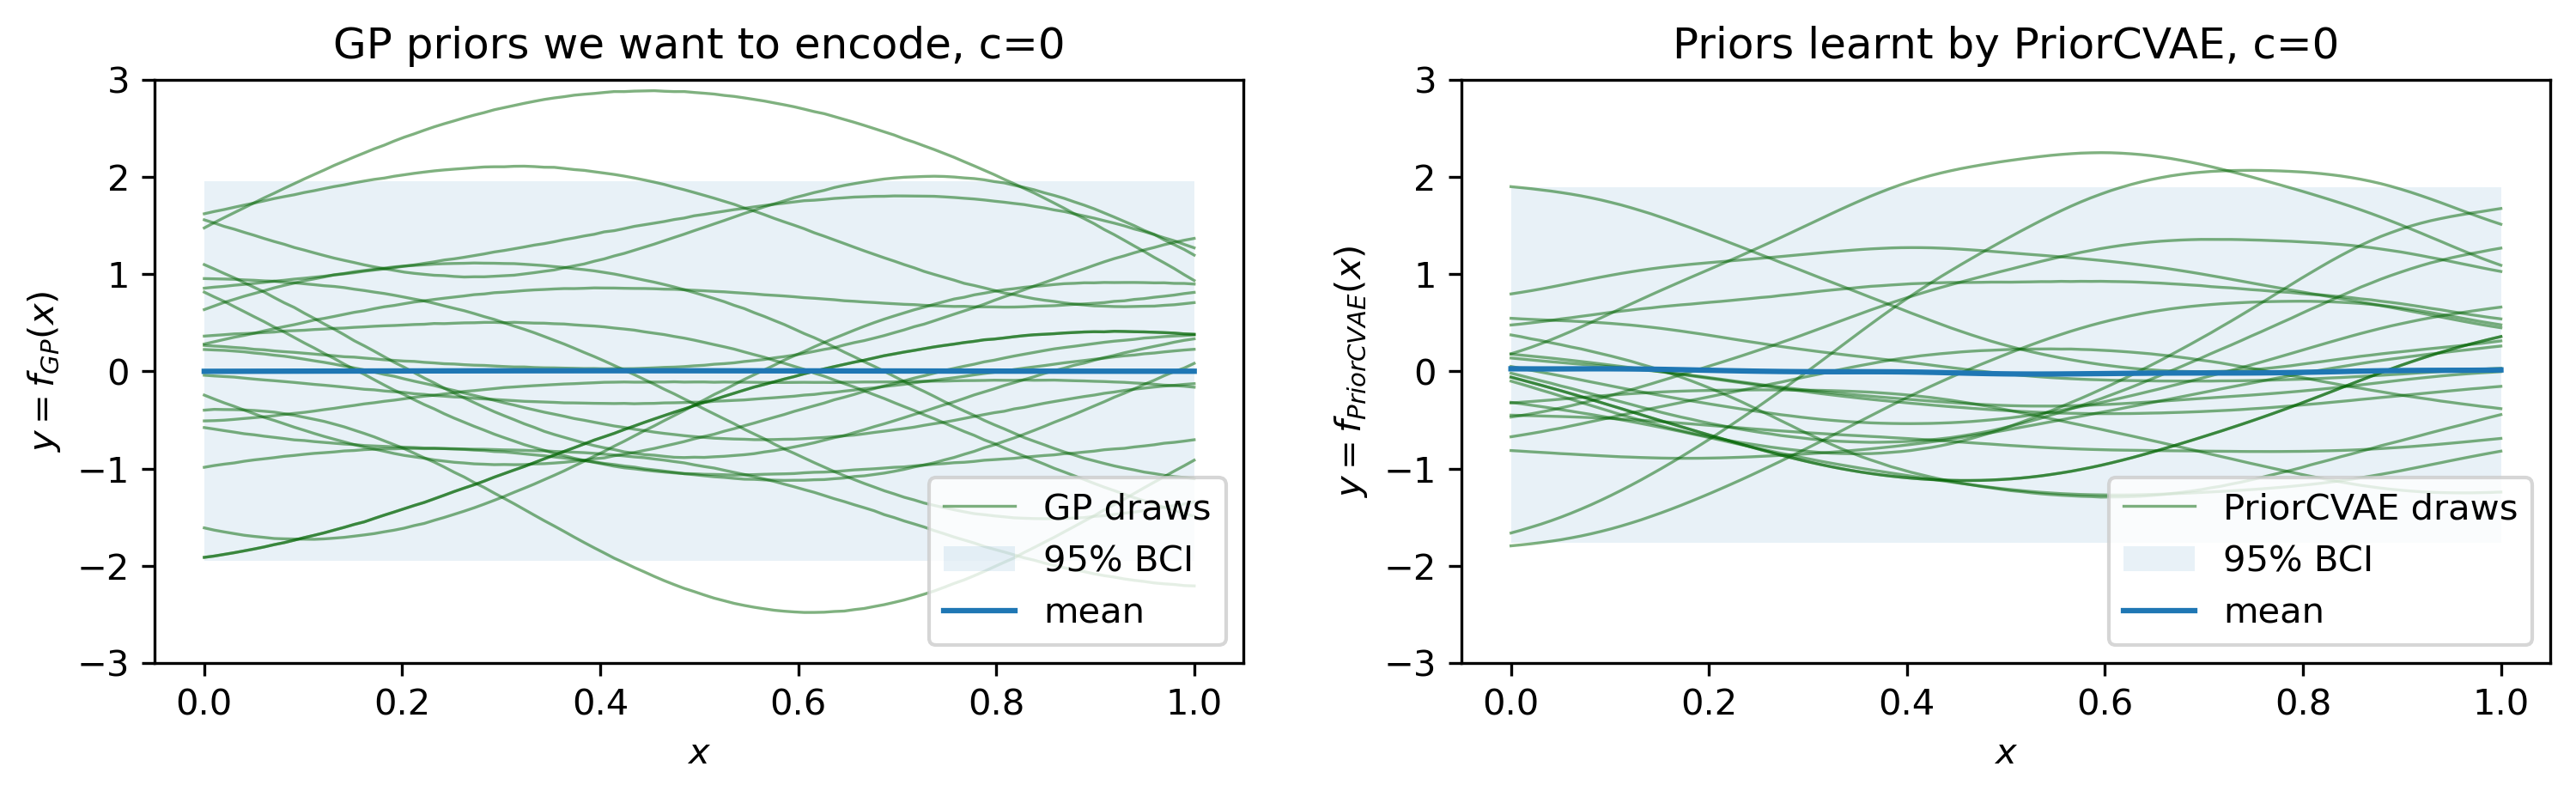

In [60]:
demo_plots(u=0, plot_gp=True, plot_cov=False)

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_vis_diagnostics_c0.pdf'.format(n))

10.447201356806525


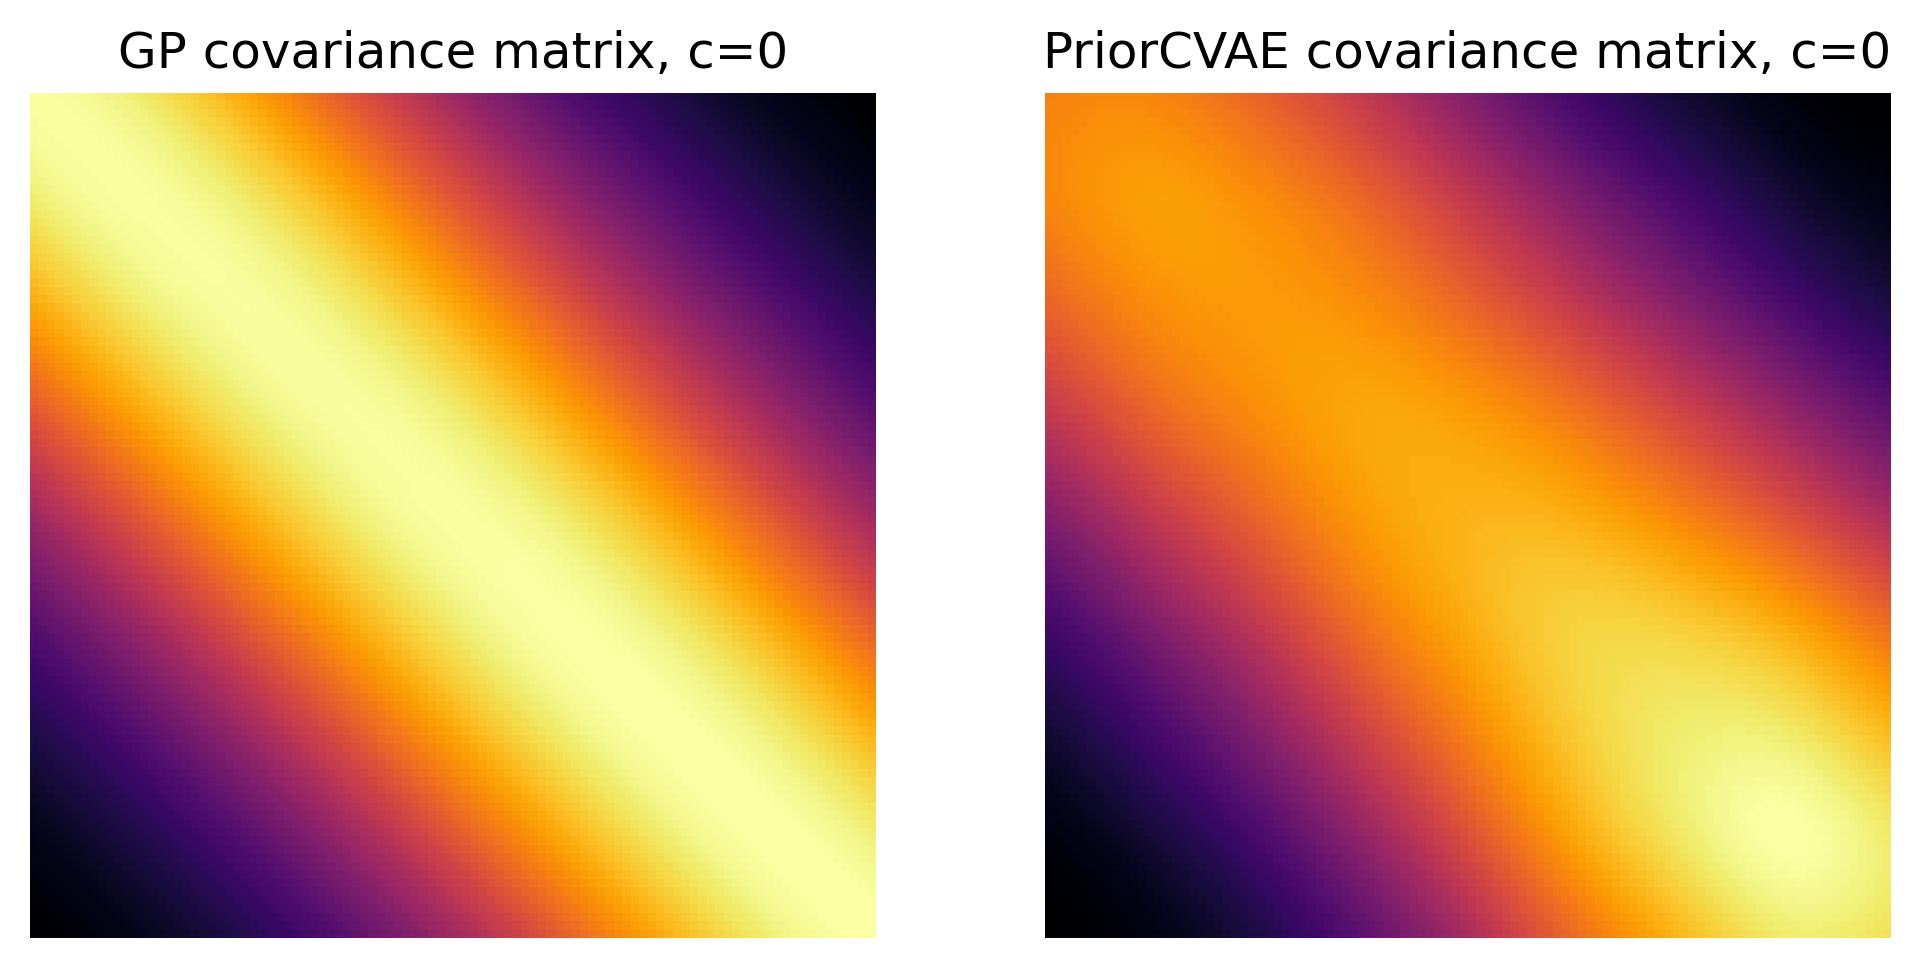

In [61]:
demo_plots(u=0, plot_gp=False, plot_cov=True)

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_cov_mat_c0.pdf'.format(n))

13.14864714662456


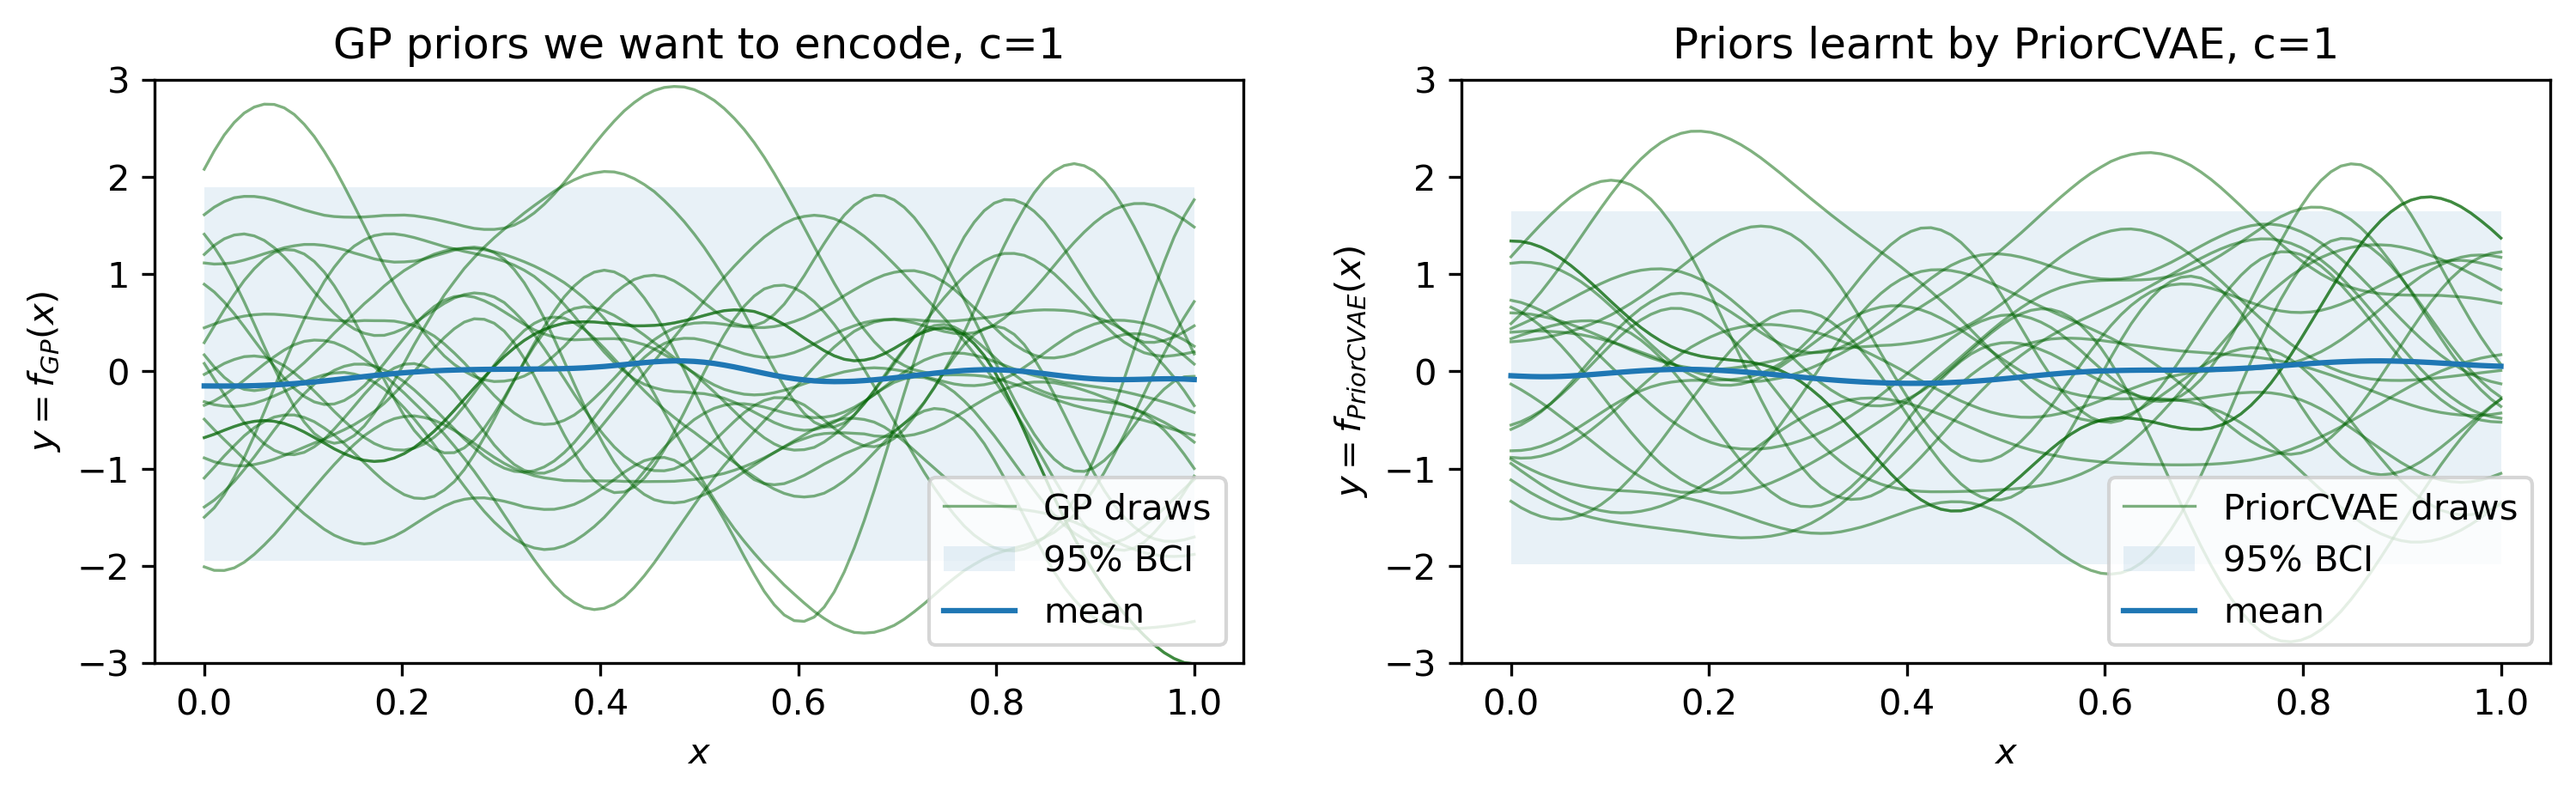

In [63]:
demo_plots(u=1, n_samps=100)

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_vis_diagnostics_c1.pdf'.format(n))

13.297694687126976


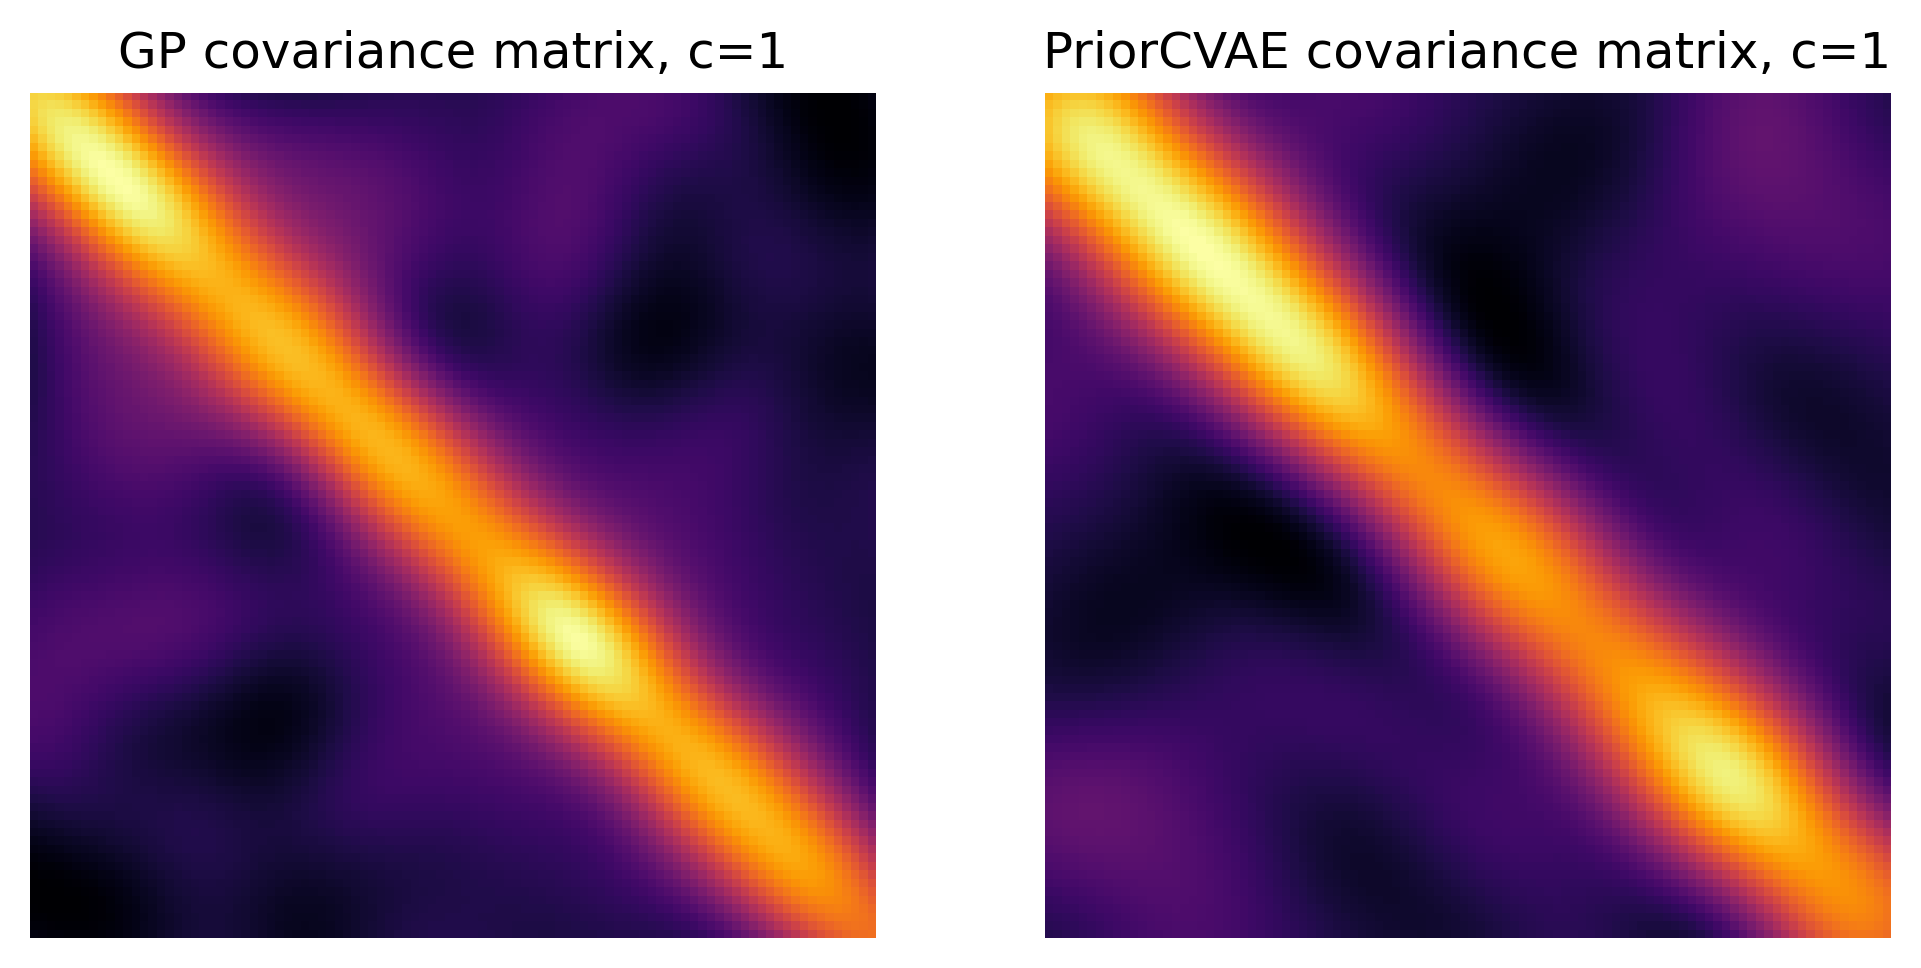

In [64]:
demo_plots(u=1, plot_gp=False, plot_cov=True, n_samps=100)

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_cov_mat_c1.pdf'.format(n))

# Inference

## Ground truth data

Text(0.5, 1.0, 'Ground truth, corresponds to c=1')

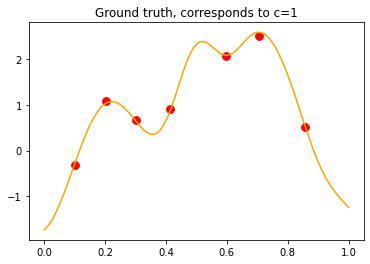

In [28]:
# generate ground truth
x = dataset.x[0,:]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)

draws = gp_predictive(rng_key_draw, x=x, gp_kernel =exp_sq_kernel, jitter=1e-6, noise=True, u=args["c"])

gp_draw = draws['f'].T
y_draw = draws['y'].T

obs_idx_lst = []
obs_idx_lst.append([10, 20, 30, 41, 59, 70, 85])
i = 0

# choose indices of data points for inference
obs_idx = jnp.array(obs_idx_lst[i])

y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

args['y'] = y_obs
args['obs_idx'] = obs_idx

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to c=' + str(args["c"]))

In [29]:
# decoder parameters

model = model.to('cpu')
decoder_dict = model.decoder.state_dict()
decoder_dict.keys()

W1 = decoder_dict['linear.weight'].T.numpy()
B1 = decoder_dict['linear.bias'].numpy()
W2 = decoder_dict['out.weight'].T.numpy()
B2 = decoder_dict['out.bias'].T.numpy()

print(W1.shape)
print(B1.shape)
print(W2.shape)
print(B2.shape)

(51, 70)
(70,)
(70, 100)
(100,)


/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_9374/2358429211.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484782168/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  B2 = decoder_dict['out.bias'].T.numpy()


## Numpyro model - known c

In [30]:
def c_decoder_numpy(z, W1, B1, W2, B2, c):
   
    def linear(z, W, B):
        lin_out = jnp.matmul(z, W) + B
        return lin_out

    if c is not None:

        c = jnp.array(c).reshape(1)
        z = jnp.concatenate([z, c], axis=0)

    hidden = jax.nn.relu(linear(z, W1, B1))
    out = linear(hidden, W2, B2)
    return out

def numpyro_model(z_dim, y=None, obs_idx=None, c=None):

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim))) 
    
    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))
    sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))

    if y is None: 
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else:
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [31]:
def run_mcmc_vae(rng_key, numpyro_model, args, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(numpyro_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, args["z_dim"], args["y"], args["obs_idx"], args["c"])
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()

## Inference on observed data - assume known long lengthscale


In [32]:
args["c"]

1

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]


MCMC elapsed time: 7.529797077178955


Text(0.5, 0, '$x$')

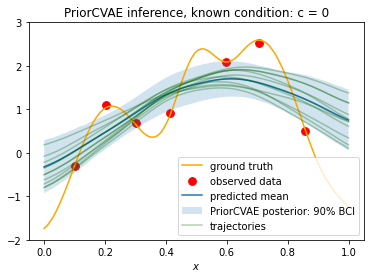

In [34]:
args["c"] = 0

rng_key, rng_key_post, rng_key_pred, rng_key_draw = random.split(rng_key_draw, 4)
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_vae(rng_key_post, numpyro_model, args)

predictive = Predictive(numpyro_model, mcmc_samples)

predictions_c0 = predictive(rng_key_pred, z_dim=args["z_dim"], c=args["c"])["f"]
mean_post_pred_c0 = jnp.mean(predictions_c0, axis=0)
hpdi_post_pred_c0 = hpdi(predictions_c0, 0.95)

i = 0
n_dats = [2]

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_c0, label="predicted mean")
plt.fill_between(x, hpdi_post_pred_c0[0], hpdi_post_pred_c0[1], alpha=0.2, interpolate=True, label="PriorCVAE posterior: 90% BCI")
for j in range(N_lines):
    plt.plot(x, predictions_c0[j,:], alpha=0.3, color="darkgreen", label="")
plt.plot(x, predictions_c0[0,:], alpha=0.3, color="darkgreen", label="trajectories")

plt.title('PriorCVAE inference, known condition: c = 0')
plt.legend(loc=4)
plt.ylim([-2, 3])
plt.xlabel('$x$')

#n = args["input_dim"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_binary_inference_cFalse.pdf'.format(n))

## Inference on observed data - assume known short lengthscale

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]


MCMC elapsed time: 11.668919086456299


Text(0.5, 0, '$x$')

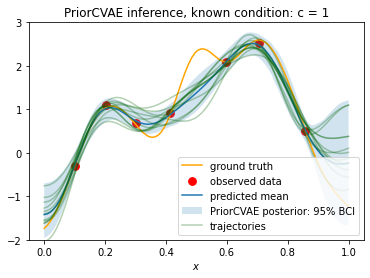

In [35]:
args["c"] = 1

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_vae(rng_key_post, numpyro_model, args)

predictive = Predictive(numpyro_model, mcmc_samples)

predictions_c1 = predictive(rng_key_pred, z_dim=args["z_dim"], c=args["c"])["f"]
mean_post_pred_c1 = jnp.mean(predictions_c1, axis=0)
hpdi_post_pred_c1 = hpdi(predictions_c1, 0.95)

i = 0
n_dats = [2]

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_c1, label="predicted mean")
plt.fill_between(x, hpdi_post_pred_c1[0], hpdi_post_pred_c1[1], alpha=0.2, interpolate=True, label="PriorCVAE posterior: 95% BCI")
for j in range(N_lines):
    plt.plot(x, predictions_c1[j,:], alpha=0.3, color="darkgreen", label="")
plt.plot(x, predictions_c1[0,:], alpha=0.3, color="darkgreen", label="trajectories")

plt.title('PriorCVAE inference, known condition: c = 1')
plt.legend(loc=4)
plt.ylim([-2, 3])
plt.xlabel('$x$')

#n = args["input_dim"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_binary_inference_cTrue.pdf'.format(n))

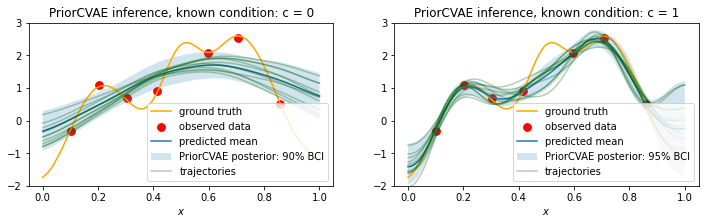

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

N_lines = 10

axs[0].plot(x, gp_draw, label="ground truth", color="orange")
axs[0].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[0].plot(x, mean_post_pred_c0, label="predicted mean")
axs[0].fill_between(x, hpdi_post_pred_c0[0], hpdi_post_pred_c0[1], alpha=0.2, interpolate=True, label="PriorCVAE posterior: 90% BCI")
for j in range(N_lines):
    axs[0].plot(x, predictions_c0[j,:], alpha=0.3, color="darkgreen", label="")
axs[0].plot(x, predictions_c0[0,:], alpha=0.3, color="darkgreen", label="trajectories")

axs[0].set_title('PriorCVAE inference, known condition: c = 0')
axs[0].legend(loc=4)
axs[0].set_ylim([-2, 3])
axs[0].set_xlabel('$x$')

axs[1].plot(x, gp_draw, label="ground truth", color="orange")
axs[1].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[1].plot(x, mean_post_pred_c1, label="predicted mean")
axs[1].fill_between(x, hpdi_post_pred_c1[0], hpdi_post_pred_c1[1], alpha=0.2, interpolate=True, label="PriorCVAE posterior: 95% BCI")
for j in range(N_lines):
    axs[1].plot(x, predictions_c1[j,:], alpha=0.3, color="darkgreen", label="")
axs[1].plot(x, predictions_c1[0,:], alpha=0.3, color="darkgreen", label="trajectories")

axs[1].set_title('PriorCVAE inference, known condition: c = 1')
axs[1].legend(loc=4)
axs[1].set_ylim([-2, 3])
axs[1].set_xlabel('$x$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/1d_n{}_binary_inference_c0_c1.pdf'.format(n))


## Inference on observed data - unknown lengthscale. Approximate discrete condition with a Beta distribution

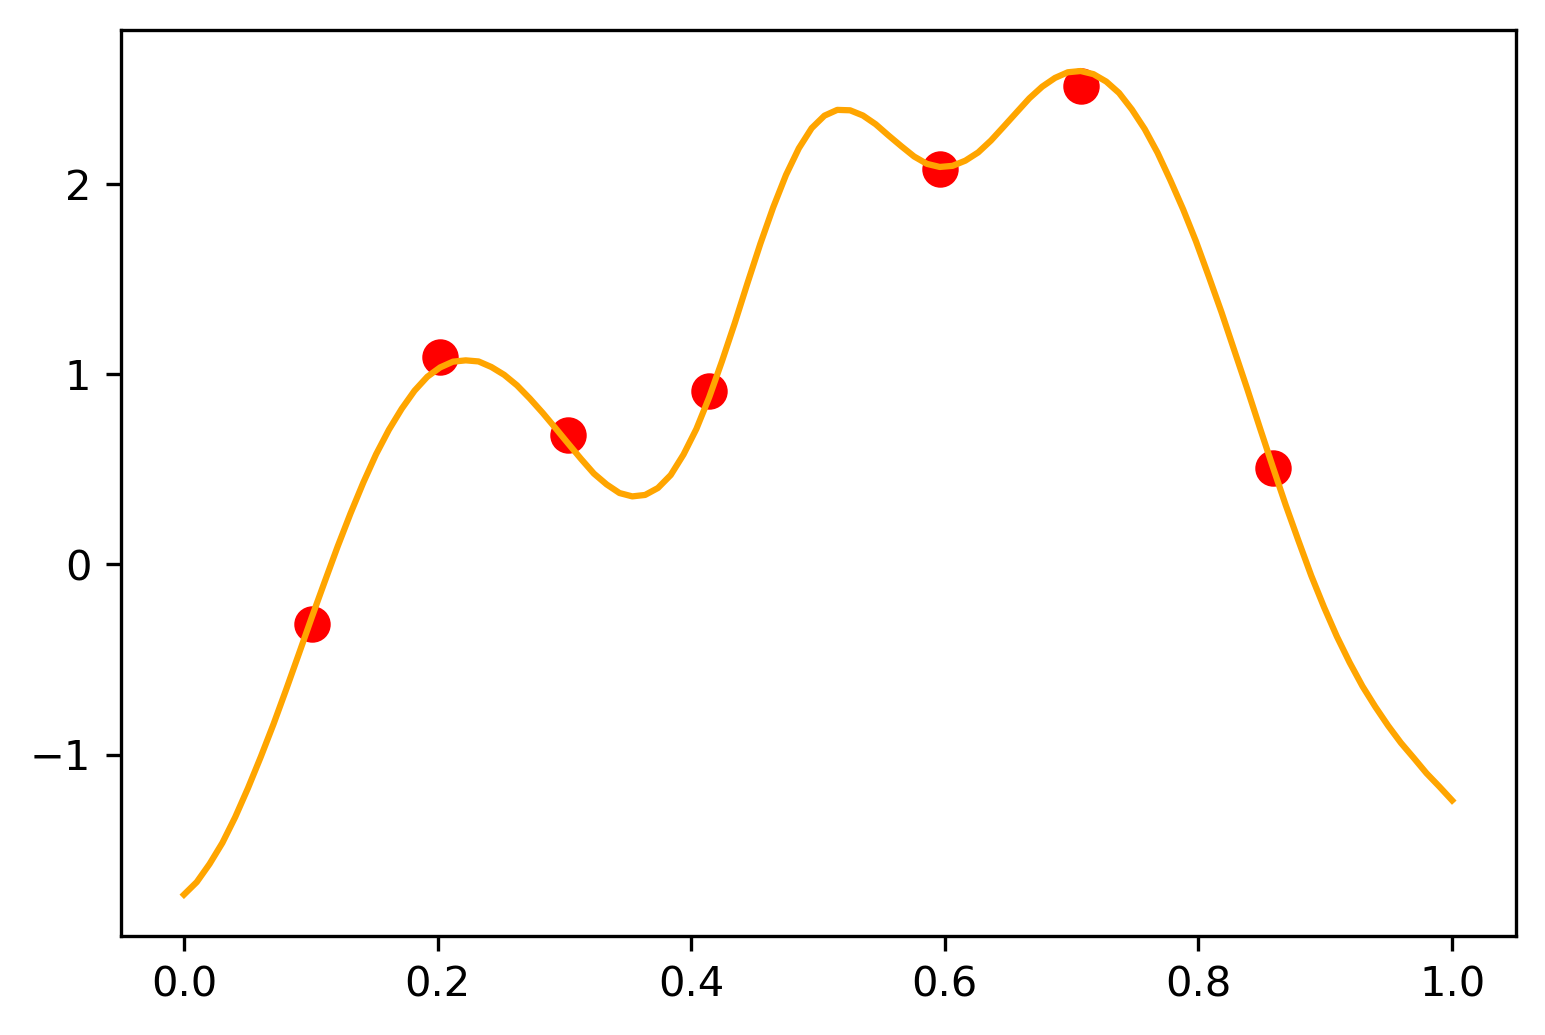

In [43]:
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)

args["c"] = None

In [44]:
def c_decoder_numpy(z, W1, B1, W2, B2, c):
   
    def linear(z, W, B):
        lin_out = jnp.matmul(z, W) + B
        return lin_out

    c = jnp.array(c).reshape(1)
    z = jnp.concatenate([z, c], axis=0)

    hidden = jax.nn.relu(linear(z, W1, B1))
    out = linear(hidden, W2, B2)
    return out

def numpyro_model(z_dim, y=None, obs_idx=None, c=None):

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))

    if c is None:
        c = numpyro.sample("c", npdist.Beta(1e-4,1e-4))

    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))
    sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))

    if y is None:
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: 
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [45]:
args["c"] = None

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(numpyro_model, init_strategy=init_strategy)

start = time.time()
mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
mcmc.run(rng_key, args["z_dim"], args["y"], args["obs_idx"], args["c"])
print("\nMCMC elapsed time:", time.time() - start)

mcmc_samples = mcmc.get_samples()

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]

  0%|          | 0/101000 [00:00<?, ?it/s]


MCMC elapsed time: 33.00590419769287


In [56]:
#mcmc.print_summary(exclude_deterministic=False)

Text(0.5, 0, '$x$')

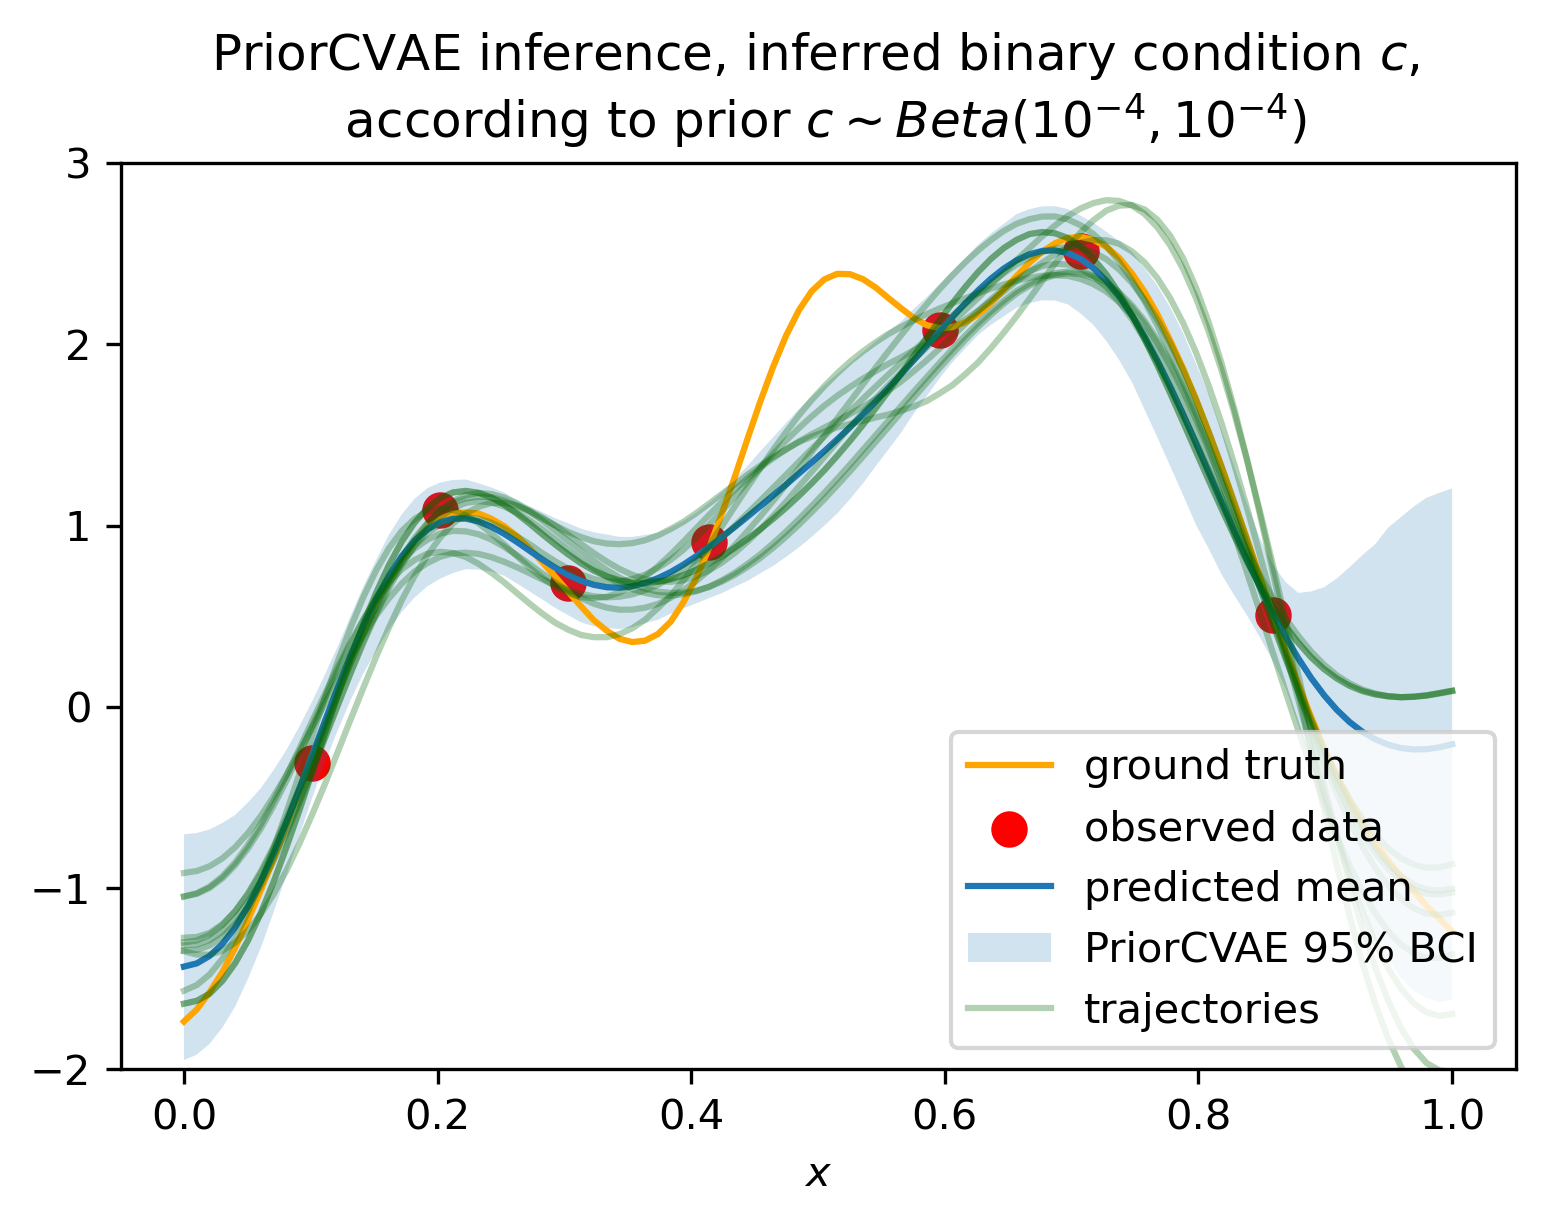

In [46]:
predictive = Predictive(numpyro_model, mcmc_samples)
predictions_beta = predictive(rng_key_pred, z_dim=args["z_dim"])["f"]
mean_post_pred_beta = jnp.mean(predictions_beta, axis=0)
hpdi_post_pred_beta = hpdi(predictions_beta, 0.95)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_beta, label="predicted mean")
plt.fill_between(x, hpdi_post_pred_beta[0], hpdi_post_pred_beta[1], alpha=0.2, interpolate=True, label="PriorCVAE 95% BCI")
for j in range(N_lines):
    plt.plot(x, predictions_beta[j,:], alpha=0.3, color="darkgreen", label="")
plt.plot(x, predictions_beta[0,:], alpha=0.3, color="darkgreen", label="trajectories")

plt.title('PriorCVAE inference, inferred binary condition $c$, \n according to prior $c\sim Beta(10^{-4},10^{-4})$')
plt.legend(loc=4)
plt.ylim([-2, 3])
plt.xlabel('$x$')

#n = args["input_dim"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_binary_inference_cBeta.pdf'.format(n))

Text(0.5, 0, '$c$')

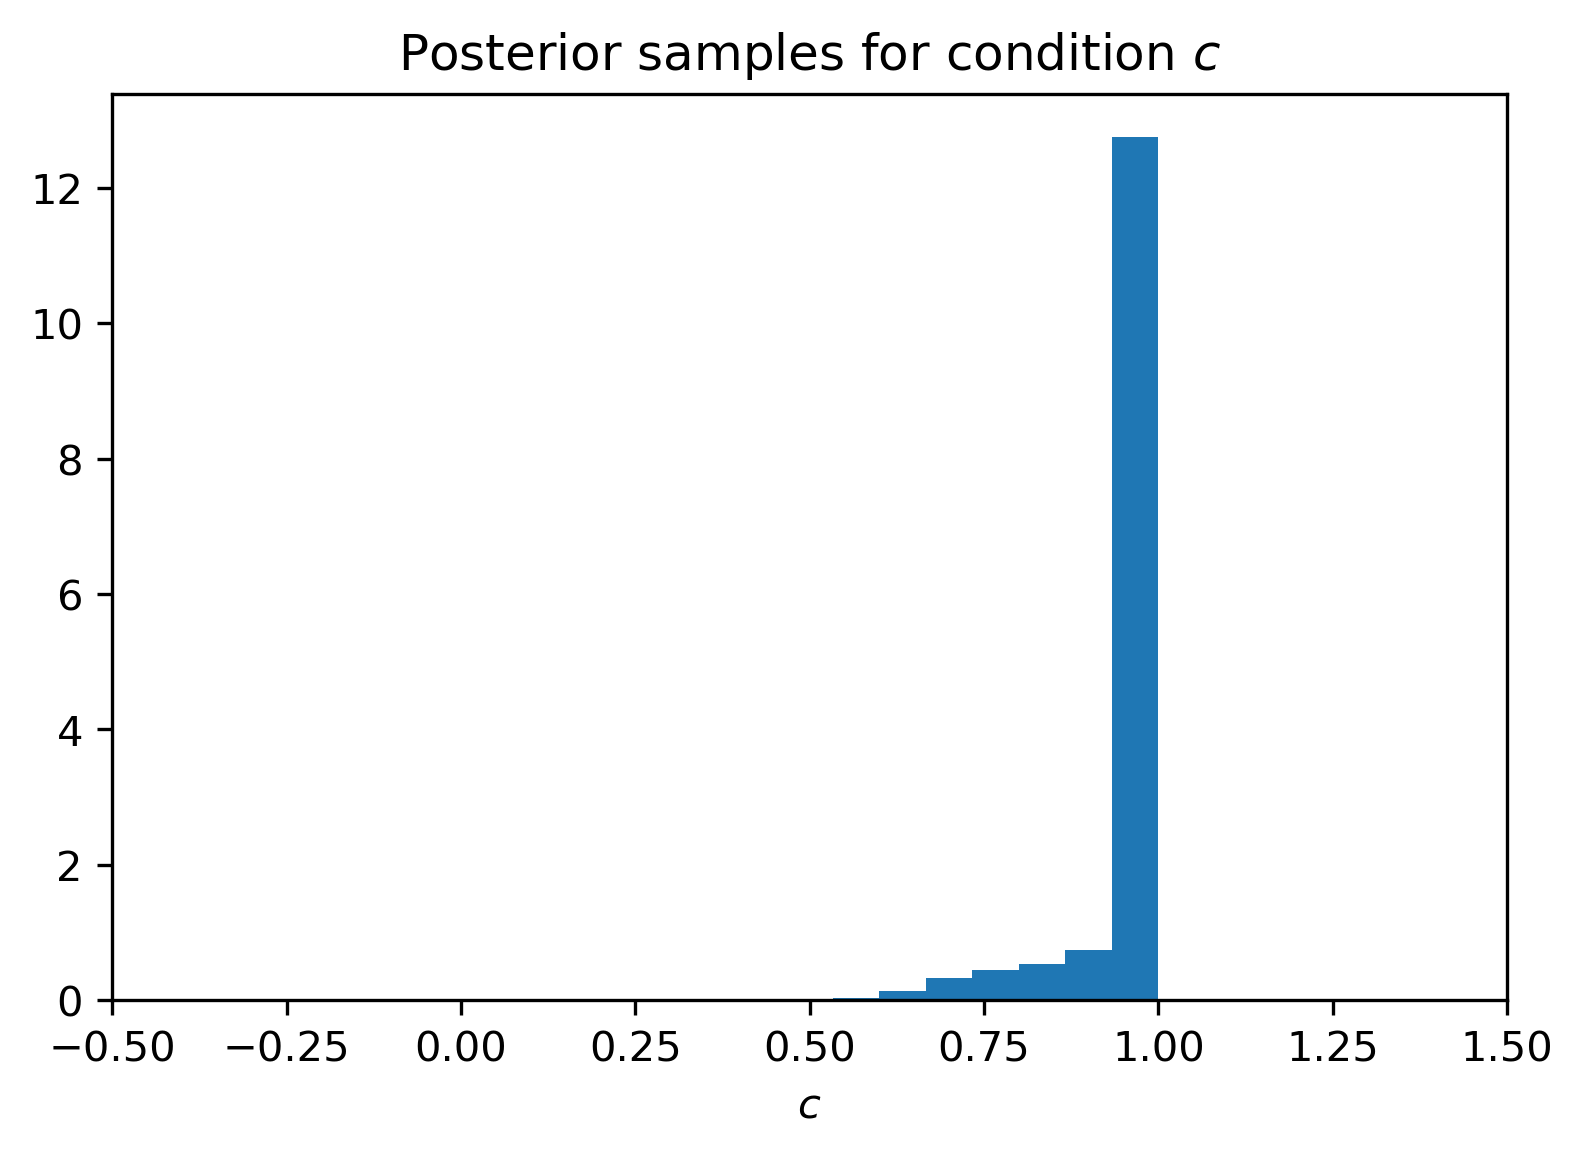

In [47]:
c_samps_bet = mcmc_samples['c']
plt.hist(c_samps_bet, density=True, bins=15) 
plt.xlim(-0.5,1.5)
plt.title('Posterior samples for condition $c$')
plt.xlabel('$c$')

#n = args["input_dim"]
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_binary_inference_cBetaPosterior.pdf'.format(n))

# Inference - discrete latent variable - MixedHMC

In [48]:
from numpyro.infer import HMC, MixedHMC

In [49]:
def numpyro_model(z_dim, y=None, obs_idx=None):

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    c = numpyro.sample("c", npdist.Bernoulli(0.5))  
    
    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))
    sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))

    if y is None: 
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: 
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [50]:
#kernel = MixedHMC(HMC(numpyro_model, trajectory_length=1.2), num_discrete_updates=20)
kernel = MixedHMC(HMC(numpyro_model), num_discrete_updates=5)
mcmc = MCMC(kernel, num_warmup=args["num_warmup"], num_samples=args["num_samples"], progress_bar=True)

In [51]:
start = time.time()
mcmc.run(random.PRNGKey(0), args["z_dim"], args["y"], args["obs_idx"])
print("\nMCMC elapsed time:", time.time() - start)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 101000/101000 [09:04<00:00, 185.64it/s, 36 steps of size 1.81e-01. acc. prob=0.82]



MCMC elapsed time: 546.5697989463806


In [53]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.00      0.01      1.00      1.00      1.00  53856.26      1.00
     noise      0.12      0.06      0.10      0.02      0.21   6998.99      1.00
      z[0]     -0.00      1.00      0.01     -1.65      1.64   5786.49      1.00
      z[1]      0.03      0.99      0.04     -1.63      1.64    341.96      1.00
      z[2]      1.56      0.35      1.57      1.00      2.14  46542.18      1.00
      z[3]      0.01      0.97      0.03     -1.53      1.68    700.23      1.01
      z[4]      0.10      1.02      0.11     -1.67      1.68    155.70      1.00
      z[5]     -0.03      1.00     -0.03     -1.65      1.64 109432.41      1.00
      z[6]      0.01      1.00      0.01     -1.63      1.62  47471.02      1.00
      z[7]     -0.03      1.00     -0.03     -1.64      1.61   1090.97      1.00
      z[8]      0.05      0.99      0.05     -1.57      1.70   2677.70      1.00
      z[9]      0.00      1

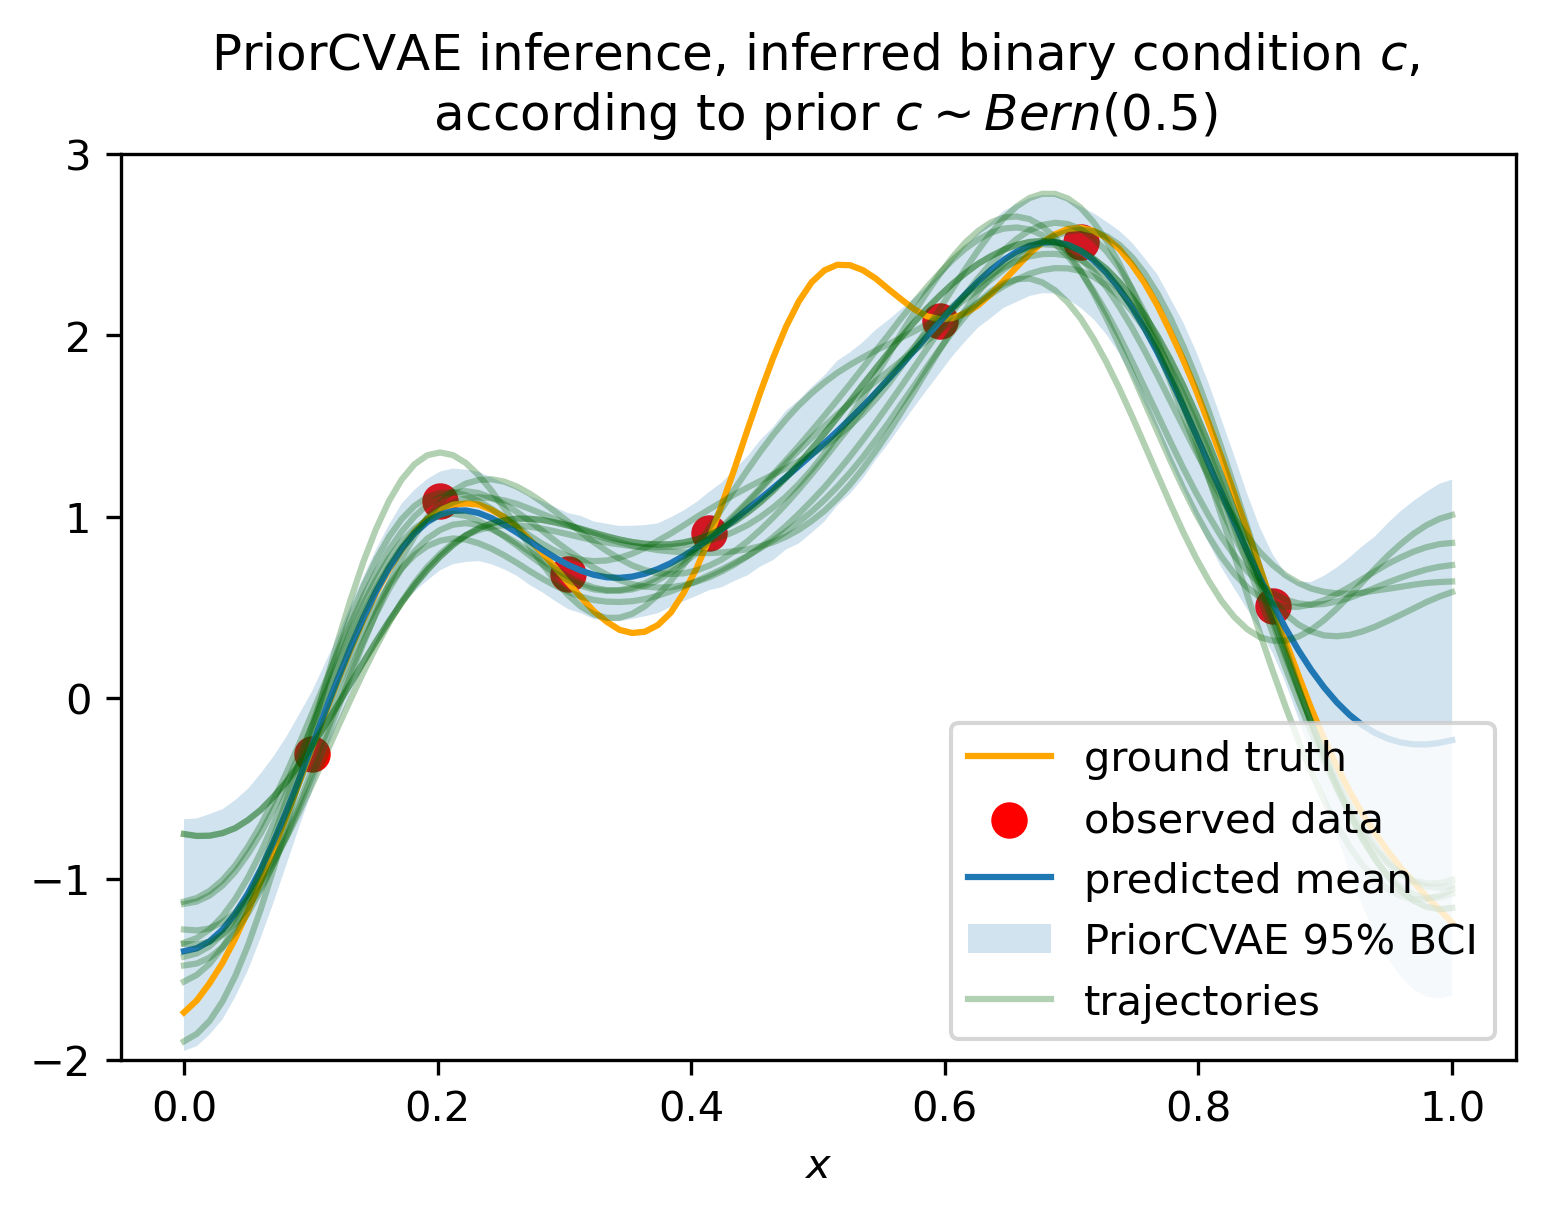

In [56]:
mcmc_samples = mcmc.get_samples()

predictive = Predictive(numpyro_model, mcmc_samples)
predictions_bern = predictive(rng_key_pred, z_dim=args["z_dim"])["f"]
mean_post_pred_bern = jnp.mean(predictions_bern, axis=0)
hpdi_post_pred_bern = hpdi(predictions_bern, 0.95)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_bern, label="predicted mean")
plt.fill_between(x, hpdi_post_pred_bern[0], hpdi_post_pred_bern[1], alpha=0.2, interpolate=True, label="PriorCVAE 95% BCI")
for j in range(N_lines):
    plt.plot(x, predictions_bern[j,:], alpha=0.3, color="darkgreen", label="")
plt.plot(x, predictions_bern[0,:], alpha=0.3, color="darkgreen", label="trajectories")

plt.title('PriorCVAE inference, inferred binary condition $c$, \n according to prior $c\sim Bern(0.5)$')
plt.legend(loc=4)
plt.ylim([-2, 3])
plt.xlabel('$x$')

#n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_binary_inference_cBern.pdf'.format(n))

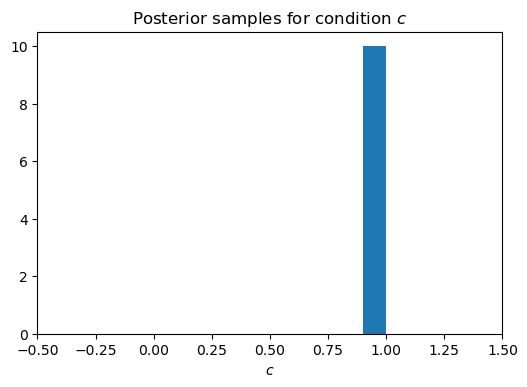

In [57]:
c_samps_bern = mcmc_samples['c']
plt.hist(c_samps_bern, density=True, bins=10) 
plt.xlim(-0.5,1.5)
plt.title('Posterior samples for condition $c$')
plt.xlabel('$c$')

#n = args["input_dim"]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_binary_inference_cBernPosterior.pdf'.format(n))

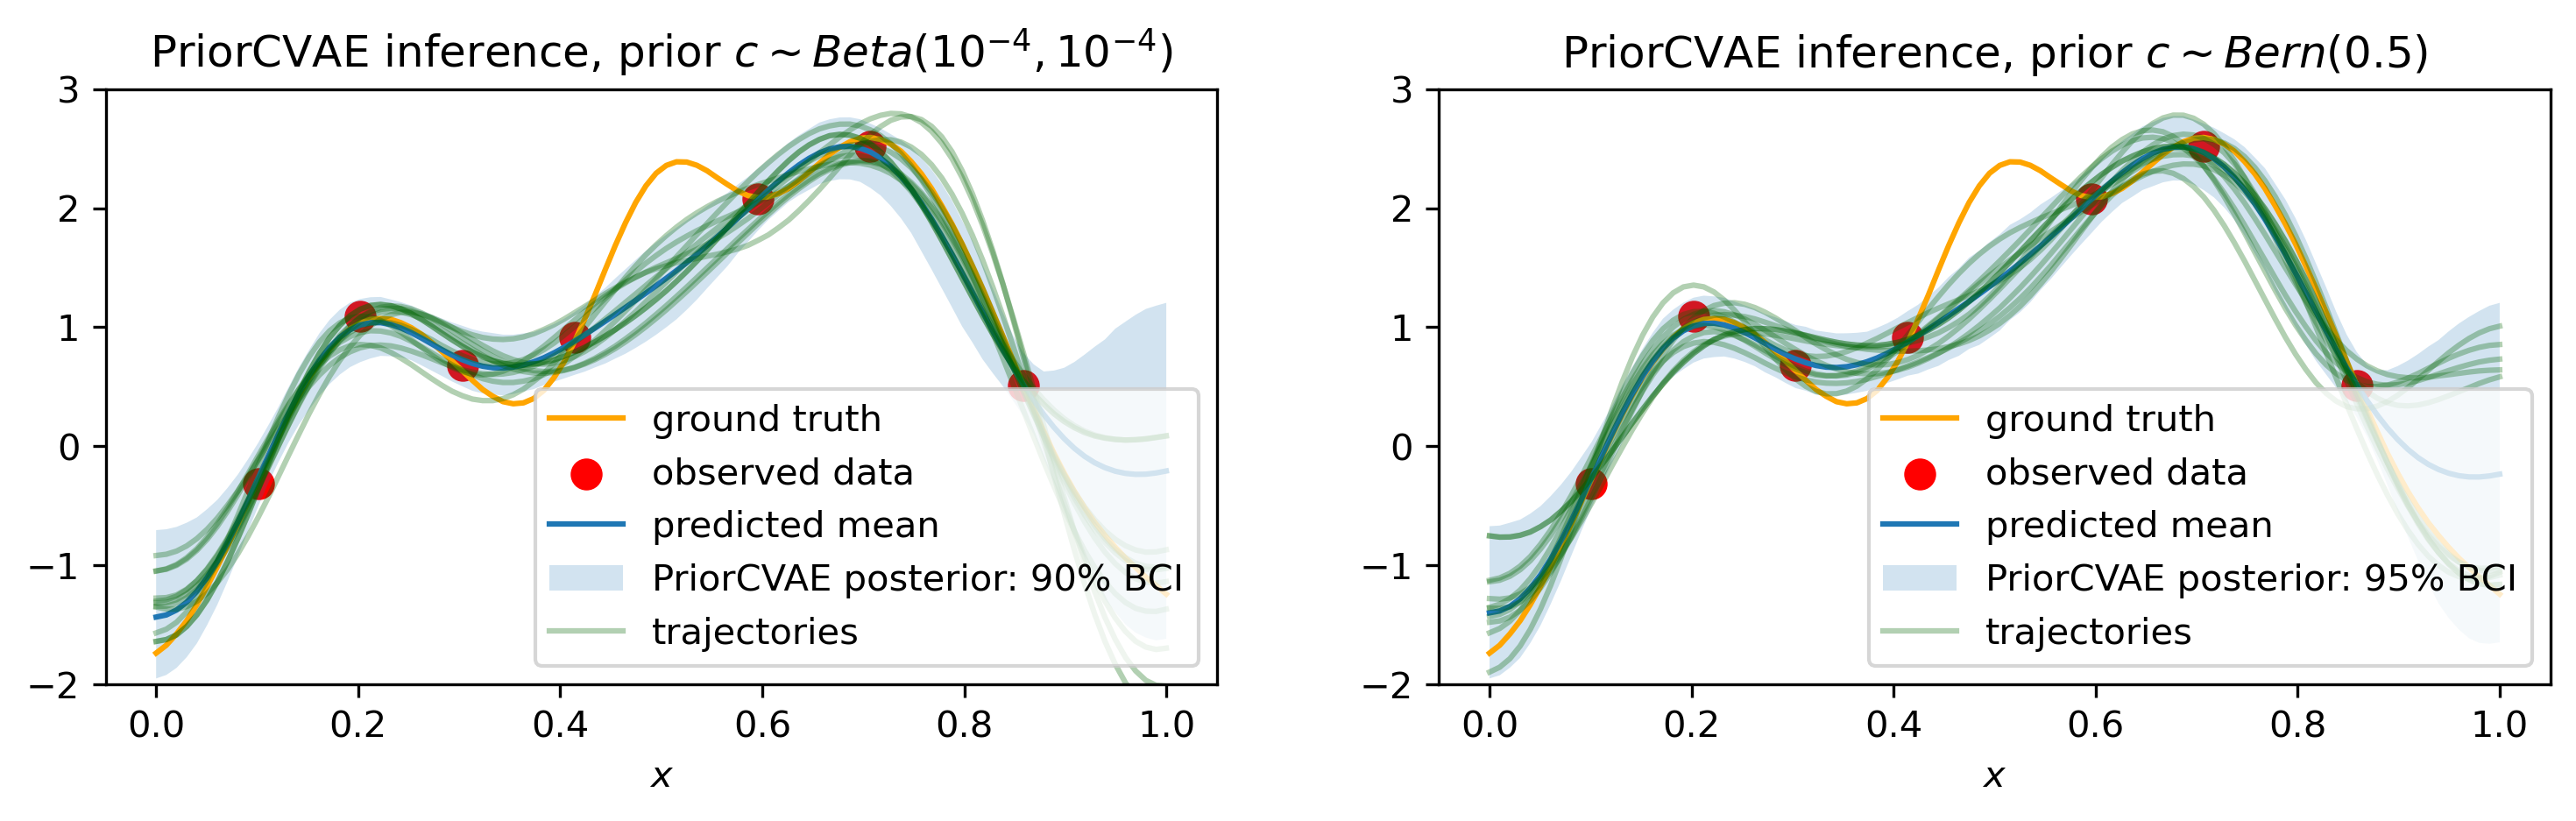

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

N_lines = 10

axs[0].plot(x, gp_draw, label="ground truth", color="orange")
axs[0].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[0].plot(x, mean_post_pred_beta, label="predicted mean")
axs[0].fill_between(x, hpdi_post_pred_beta[0], hpdi_post_pred_beta[1], alpha=0.2, interpolate=True, label="PriorCVAE posterior: 90% BCI")
for j in range(N_lines):
    axs[0].plot(x, predictions_beta[j,:], alpha=0.3, color="darkgreen", label="")
axs[0].plot(x, predictions_beta[0,:], alpha=0.3, color="darkgreen", label="trajectories")

axs[0].set_title('PriorCVAE inference, prior $c\sim Beta(10^{-4},10^{-4})$')
axs[0].legend(loc=4)
axs[0].set_ylim([-2, 3])
axs[0].set_xlabel('$x$')

axs[1].plot(x, gp_draw, label="ground truth", color="orange")
axs[1].scatter(x_obs, y_obs, color="red", label="observed data", s=60)
axs[1].plot(x, mean_post_pred_bern, label="predicted mean")
axs[1].fill_between(x, hpdi_post_pred_bern[0], hpdi_post_pred_bern[1], alpha=0.2, interpolate=True, label="PriorCVAE posterior: 95% BCI")
for j in range(N_lines):
    axs[1].plot(x, predictions_bern[j,:], alpha=0.3, color="darkgreen", label="")
axs[1].plot(x, predictions_bern[0,:], alpha=0.3, color="darkgreen", label="trajectories")

axs[1].set_title('PriorCVAE inference, prior $c\sim Bern(0.5)$')
axs[1].legend(loc=4)
axs[1].set_ylim([-2, 3])
axs[1].set_xlabel('$x$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/1d_n{}_binary_inference_Beta_Bern.pdf'.format(n))


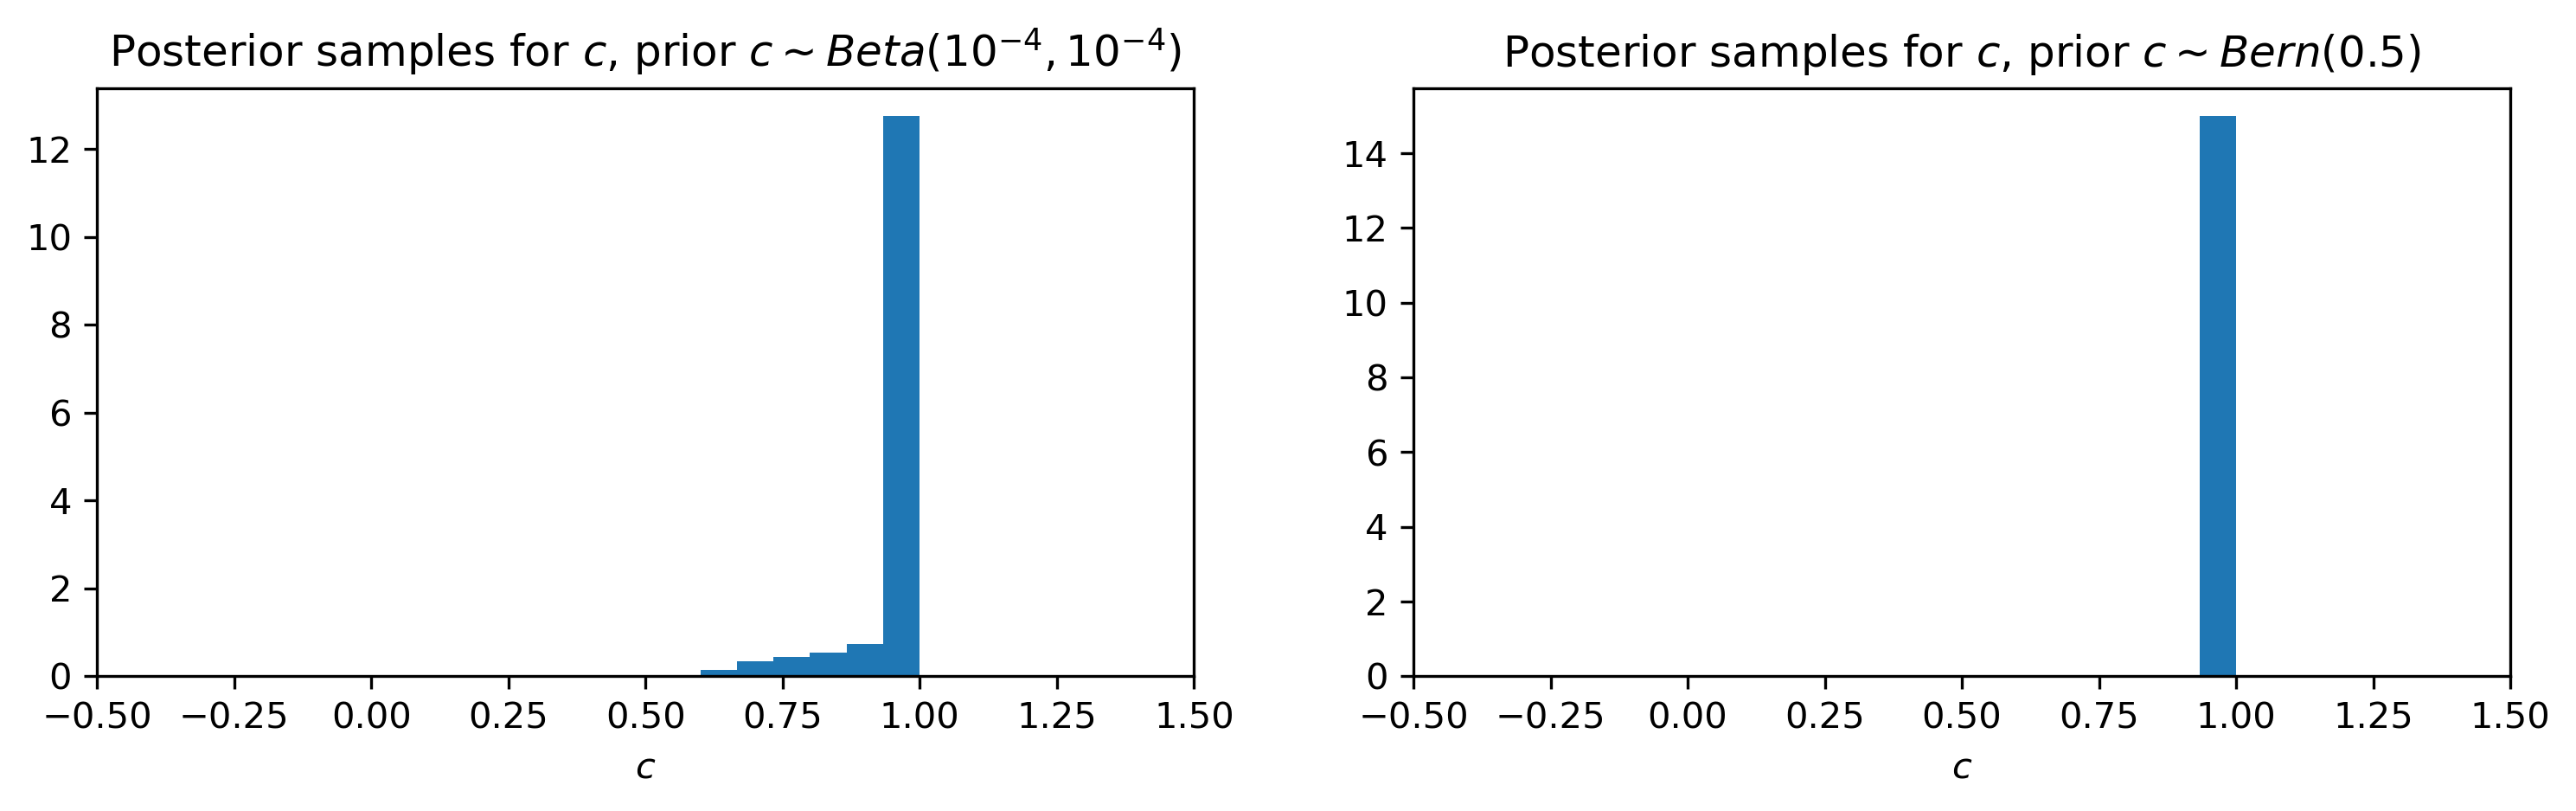

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

N_lines = 10

axs[0].hist(c_samps_bet, density=True, bins=15) 
axs[0].set_xlim(-0.5,1.5)
axs[0].set_title('Posterior samples for $c$, prior $c\sim Beta(10^{-4},10^{-4})$')
axs[0].set_xlabel('$c$')

axs[1].hist(c_samps_bern, density=True, bins=15) 
axs[1].set_xlim(-0.5,1.5)
axs[1].set_title('Posterior samples for $c$, prior $c\sim Bern(0.5)$')
axs[1].set_xlabel('$c$')

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/1d_n{}_binary_inference_Beta_Bern_posterior.pdf'.format(n))


# Inference - discrete latent variable - not working NUTS (because NUTS can't deal with discrete variables)

In [55]:
!pip install funsor

def numpyro_model(z_dim, y=None, obs_idx=None):

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    c = numpyro.sample("c", npdist.Bernoulli(0.5))  
    
    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))
    sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))

    if y is None: 
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: 
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)
        
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(numpyro_model, init_strategy=init_strategy)
mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
mcmc.run(rng_key, args["z_dim"], args["y"], args["obs_idx"])

mcmc_Samples = mcmc.get_samples()

/opt/anaconda3/envs/numpyro10_torch/lib/python3.8/site-packages/jax/linear_util.py:167: FutureWarning: Some algorithms will automatically enumerate the discrete latent site c of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


ValueError: Missing a plate statement for batch dimension -1 at site 'z'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.